<a href="https://colab.research.google.com/github/shrushenoy/Predicting-No-Show-Rate-for-Hospital-Appointments/blob/master/Patients%20No-Show%20Prediction%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting No-Show Rate for Hospital Appointments**
In healthcare, no-show for a scheduled appointment is one of the most significant factor that impacts the healthcare delivery services. In 2017, U.S. healthcare industry had loss of $150 billions. The no-show rate is as high as 30% in U.S, there are various factors leading to this number. A model to predict no-show accurately and to take necessary interventions can be implemented to reduce the impact on healthcare.




### Importing necessary packages

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import time
import datetime as dt
sns.set_style("whitegrid")
from scipy.stats import chi2_contingency
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [174]:
ls

'Copy of ML_proj (1).ipynb'   Dummy_ml_proj.ipynb  'my copy of ML_proj.ipynb'
'Copy of ML_proj.ipynb'       ML_proj.ipynb         noshow.csv


### Data Loading

In [175]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [176]:
cd /content/gdrive/My Drive/Courses/Spring 2020/ML/project/

/content/gdrive/My Drive/Courses/Spring 2020/ML/project


In [177]:
df = pd.read_csv('noshow.csv')
df.head()

,Age,Gender,AppointmentRegistration,ApointmentData,Day,Status,Diabetes,Alcoolism,HiperTension,Handcap,Scholarship,Sms_Reminder
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0


### Data Cleaning & Exploration

In [178]:
df.shape[0]

410526

In [179]:
#renaming column to make it easier 
new_col_name = ['age', 'gender','schedule_day','appointment_day','week_day', 'no_show',
                'diabetes','alcoholism','hypertension','handicap', 'scholarship',
                'sms_received']
df.columns = new_col_name
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0


In [180]:
#checking for null values
df.isnull().sum()

age                0
gender             0
schedule_day       0
appointment_day    0
week_day           0
no_show            0
diabetes           0
alcoholism         0
hypertension       0
handicap           0
scholarship        0
sms_received       0
dtype: int64

In [0]:
#sns.heatmap(df.isnull(), cmap='viridis')

In [182]:
#creating a function to find unique values for each feature 

def data(df, limit=5):  
    print(f"Dataset Shape: {df.shape}")
    print('Unique values in feature: ')
    print(df.nunique())
        
data(df)

Dataset Shape: (410526, 12)
Unique values in feature: 
age                   110
gender                  2
schedule_day       398972
appointment_day       561
week_day                6
no_show                 2
diabetes                2
alcoholism              2
hypertension            2
handicap                5
scholarship             2
sms_received            2
dtype: int64


In [183]:
#basic statistics 
df.describe()

,age,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received
count,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000,410526.000000
mean,37.614465,0.076324,0.026461,0.210871,0.020988,0.097268,0.478727
std,22.892679,0.265516,0.160502,0.407927,0.157466,0.296323,0.499548
min,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,115.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000


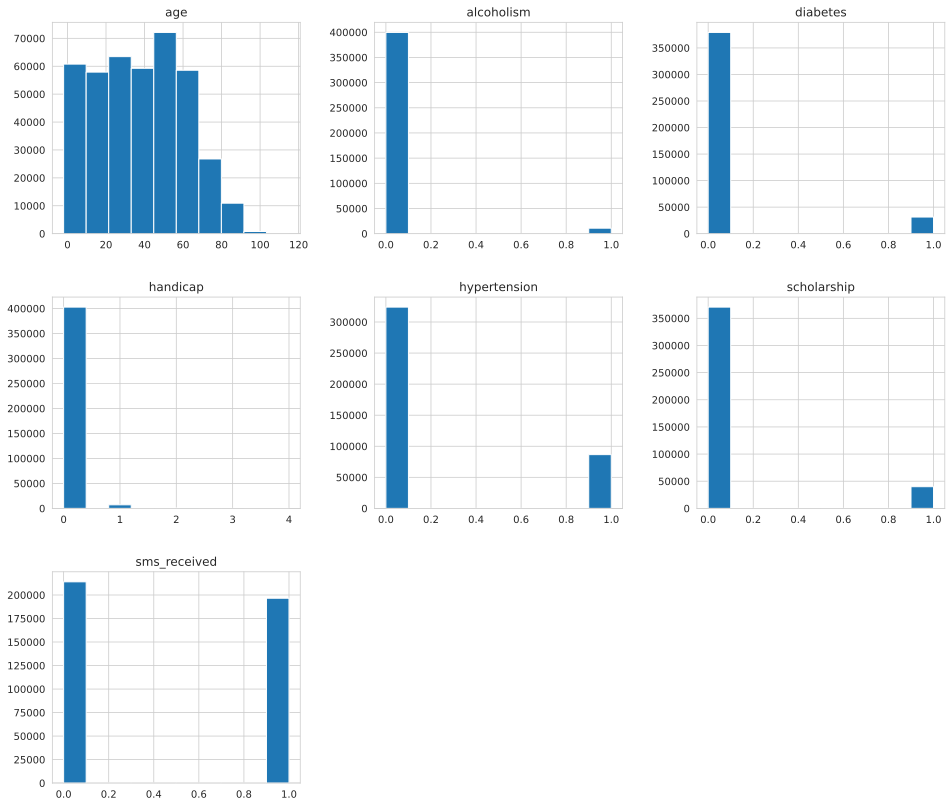

In [184]:
df.hist(figsize=(16,14));

In [185]:
df.no_show.unique()

array(['noshow', 'showup'], dtype=object)

Below is the split of values in 'No-show': 0 = showed up and 1 = didn't show up: 

noshow    231587
showup    178939
Name: no_show, dtype: int64

 Out of 410526 records, 178939 didn't show up, i.e. 43.59 %


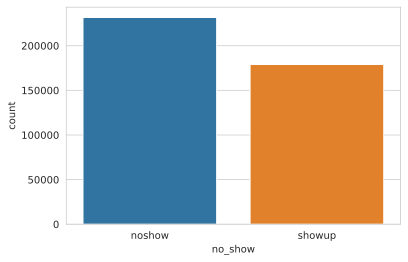

In [186]:
def no_show_class():
    '''Count the values of No-show to spot whether classes are imbalanced or not'''
    noshow = 0
    for value in df['no_show']:
        if value == 'showup':
            noshow += 1
    print ("\n Out of", len(df['no_show']), "records,", noshow, "didn't show up, i.e.", round(float(noshow) / float(len(df['no_show'])), 4)*100,"%")

print ("Below is the split of values in 'No-show': 0 = showed up and 1 = didn't show up: \n")
print (df['no_show'].value_counts())
sns.countplot(x='no_show', data=df)

no_show_class()

In [0]:
'''print(df['no_show'].value_counts())
sns.countplot(x='no_show', data=df).set_title('Show/No-show Patient')
'''

"print(df['no_show'].value_counts())\nsns.countplot(x='no_show', data=df).set_title('Show/No-show Patient')\n"

In [0]:
#Creating a fucntion to calculate probability of feature with respect to no_show
#used later in code
def probStatus(dataset, group_by):
    df = pd.crosstab(index = dataset[group_by], columns = dataset.no_show).reset_index()
    df['probShowUp'] = df['showup'] / (df['showup'] + df['noshow'])
    return data[[group_by, 'probShowUp']]

In [188]:
#checking uniques age values
print ("Age range: ", sorted(df['age'].unique()))

Age range:  [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 108, 113, 115]


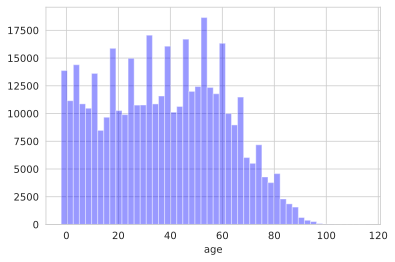

In [189]:
sns.distplot(df['age'], hist=True, kde=False, color = 'blue')
plt.show()

In [190]:
df[df['age'] > 105]

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received
42450,113,F,2014-01-30T15:42:05Z,2014-02-04T00:00:00Z,Thursday,noshow,0,0,1,0,0,0
146771,113,F,2013-12-26T13:38:36Z,2014-01-09T00:00:00Z,Thursday,noshow,0,0,1,0,0,1
261053,113,F,2014-09-11T15:11:05Z,2014-09-12T00:00:00Z,Thursday,showup,0,0,0,1,0,0
261754,108,F,2014-08-19T13:37:44Z,2014-08-20T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0
363911,115,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,Monday,noshow,0,0,0,1,0,0
363914,115,F,2016-05-16T09:17:44Z,2016-05-19T00:00:00Z,Monday,noshow,0,0,0,1,0,0
368126,115,F,2016-04-08T14:29:17Z,2016-05-16T00:00:00Z,Friday,noshow,0,0,0,1,0,0
376283,115,F,2016-05-30T09:44:51Z,2016-05-30T00:00:00Z,Monday,showup,0,0,0,1,0,0
397665,115,F,2016-05-19T07:57:56Z,2016-06-03T00:00:00Z,Thursday,showup,0,0,1,0,0,1


In [191]:
# dropping -ve age and row above 105 years
df = df[(df.age >= 0) & (df.age <= 105)]

min_age = df['age'].min()
max_age = df['age'].max()
print ("Age now spans values from: {} to {}.".format(min_age, max_age))

Age now spans values from: 0 to 104.


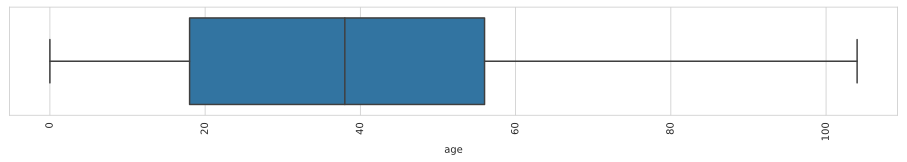

In [192]:
plt.figure(figsize=(16,2))
plt.xticks(rotation=90)
sns.boxplot(x=df.age)

In [193]:
#Creating bins for age groups 
age_ranges = [0, 12, 18, 25, 60, 75]
age_names = ["Children", "Teenager", 'Young-Adult', 'Adult', 'Senior']

df['age_bin'] = pd.cut(np.array(df['age']),bins=age_ranges, labels=age_names)
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,age_bin
0,19,M,2014-12-16T14:46:25Z,2015-01-14T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0,Young-Adult
1,24,F,2015-08-18T07:01:26Z,2015-08-19T00:00:00Z,Tuesday,noshow,0,0,0,0,0,0,Young-Adult
2,4,F,2014-02-17T12:53:46Z,2014-02-18T00:00:00Z,Monday,noshow,0,0,0,0,0,0,Children
3,5,M,2014-07-23T17:02:11Z,2014-08-07T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0,Children
4,38,M,2015-10-21T15:20:09Z,2015-10-27T00:00:00Z,Wednesday,noshow,0,0,0,0,0,0,Adult


In [194]:
#checking unique age groups
df.age_bin.unique()

[Young-Adult, Children, Adult, Senior, Teenager, NaN]
Categories (5, object): [Children < Teenager < Young-Adult < Adult < Senior]

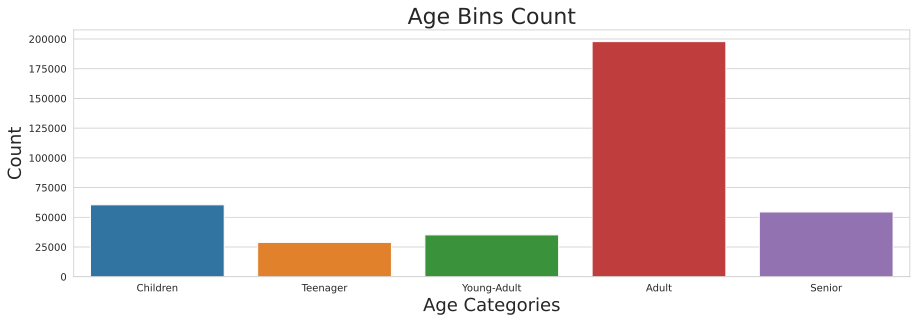

In [195]:
# now stack and reset
show_prob_age = pd.crosstab(df['age_bin'], df['no_show'], normalize='index')
plt.figure(figsize=(15,10))
plt.subplot(211)
ax1 = sns.countplot(x="age_bin", data=df)
ax1.set_title("Age Bins Count", fontsize=22)
ax1.set_xlabel("Age Categories", fontsize=18)
ax1.set_ylabel("Count", fontsize=18)

plt.show()

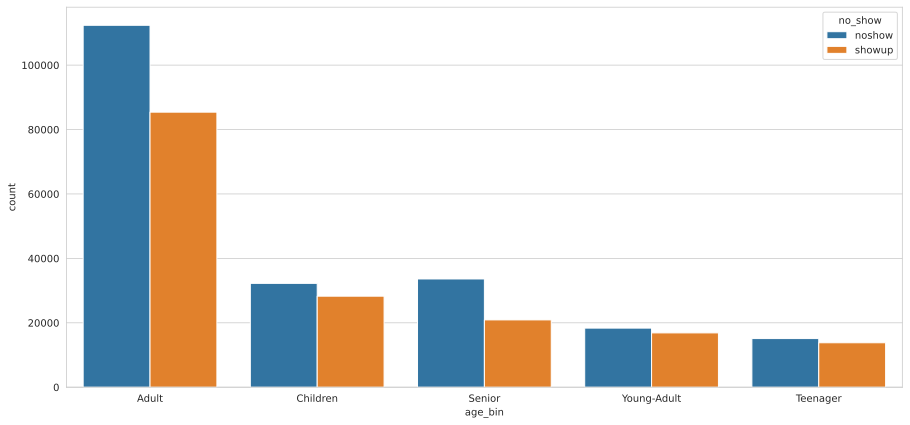

In [196]:
plt.figure(figsize = (15,7))
sns.countplot(x='age_bin', hue='no_show', data=df, order = df['age_bin'].value_counts().index)

In [0]:
sns.lmplot(data = probStatus(df, 'age'), x = 'age', y = 'probShowUp', 
           fit_reg = True, line_kws={'color': 'red'})
print('\bProbability of showing up with respect to Age')

In [198]:

#Converting the schedule and appointment date from ISO8601 to standard format
df.schedule_day = df.schedule_day.apply(np.datetime64)
df.appointment_day = df.appointment_day.apply(np.datetime64)

print(df.schedule_day.head())
print(df.appointment_day.head())

0   2014-12-16 14:46:25
1   2015-08-18 07:01:26
2   2014-02-17 12:53:46
3   2014-07-23 17:02:11
4   2015-10-21 15:20:09
Name: schedule_day, dtype: datetime64[ns]
0   2015-01-14
1   2015-08-19
2   2014-02-18
3   2014-08-07
4   2015-10-27
Name: appointment_day, dtype: datetime64[ns]


In [199]:
#calculating waiting time 
appointment_waiting_time = df['appointment_day'] - df['schedule_day']
appointment_waiting_time = appointment_waiting_time.apply(lambda x: x.total_seconds() / (3600 * 24))

#adding column waiting_time into dataframe
df['waiting_time'] = appointment_waiting_time.round(1)
df.head(3)

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,age_bin,waiting_time
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,28.4
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,0.7
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,Children,0.5


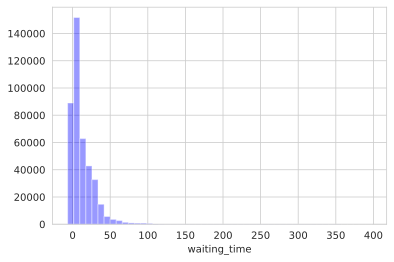

In [201]:
#sns.stripplot(data = df, y = 'waiting_time', jitter = True)
sns.distplot(df['waiting_time'], hist=True, kde=False, color = 'blue')
plt.show()

In [202]:
#checking for number of rows for waiting time less than 0
df[df['waiting_time'] < 0]

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,age_bin,waiting_time
299999,62,F,2016-04-29 18:38:08,2016-04-29,Friday,showup,0,0,1,0,0,0,Senior,-0.8
300000,56,M,2016-04-29 16:08:27,2016-04-29,Friday,showup,0,0,0,0,0,0,Adult,-0.7
300001,62,F,2016-04-29 16:19:04,2016-04-29,Friday,showup,0,0,0,0,0,0,Senior,-0.7
300002,8,F,2016-04-29 17:29:31,2016-04-29,Friday,showup,0,0,0,0,0,0,Children,-0.7
300003,56,F,2016-04-29 16:07:23,2016-04-29,Friday,showup,1,0,1,0,0,0,Adult,-0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410510,14,F,2016-06-08 08:50:20,2016-06-08,Wednesday,showup,0,0,0,0,0,0,Teenager,-0.4
410511,41,F,2016-06-08 08:20:01,2016-06-08,Wednesday,showup,0,0,0,0,0,0,Adult,-0.3
410512,2,M,2016-06-08 07:52:55,2016-06-08,Wednesday,showup,0,0,0,0,0,0,Children,-0.3
410513,58,F,2016-06-08 08:35:31,2016-06-08,Wednesday,showup,0,0,0,0,0,0,Adult,-0.4


In [0]:
# removeing records below waiting time 0 and above 350
df = df[(df.waiting_time >= 0) & (df.waiting_time <= 350)]

In [204]:
print('Minimum waiting time is:', df['waiting_time'].min())
print('Maximum waiting time is:', df['waiting_time'].max())

Minimum waiting time is: 0.1
Maximum waiting time is: 349.6


In [0]:
print('Probability of showing up with respect to AwaitingTime')
sns.lmplot(data = probStatus(df, 'waiting_time'), x = 'waiting_time', 
           y = 'probShowUp', fit_reg = True, line_kws={'color': 'red'})

In [206]:
#Calculating appointment Month

df['appointment_month'] = df['appointment_day'].apply(lambda x : dt.datetime.strftime(x, '%B'))
df.head()

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,age_bin,waiting_time,appointment_month
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,28.4,January
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,0.7,August
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,Children,0.5,February
3,5,M,2014-07-23 17:02:11,2014-08-07,Wednesday,noshow,0,0,0,0,0,0,Children,14.3,August
4,38,M,2015-10-21 15:20:09,2015-10-27,Wednesday,noshow,0,0,0,0,0,0,Adult,5.4,October


In [207]:
#Checking unique values for appointment_month
df.appointment_month.unique()

array(['January', 'August', 'February', 'October', 'July', 'June',
       'November', 'May', 'March', 'April', 'September', 'December'],
      dtype=object)

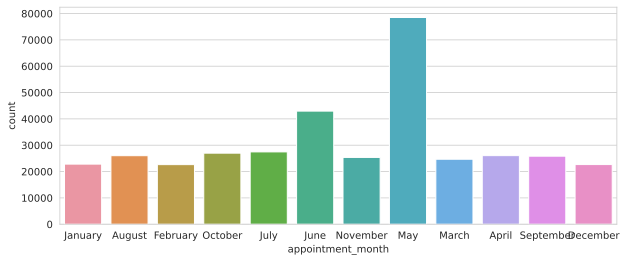

In [208]:
plt.figure(figsize = (10, 4))
sns.countplot(x='appointment_month', data = df)

In [209]:
#Creating a function to calculate hours of appointment
def calculate_hour(timestamp):
    timestamp = str(timestamp)
    hour = int(timestamp[11:13])
    minute = int(timestamp[14:16])
    second = int(timestamp[17:])
    return round(hour + minute/60 + second/3600)

df['hour_of_day'] = df.schedule_day.apply(calculate_hour)
df.head(5)

,age,gender,schedule_day,appointment_day,week_day,no_show,diabetes,alcoholism,hypertension,handicap,scholarship,sms_received,age_bin,waiting_time,appointment_month,hour_of_day
0,19,M,2014-12-16 14:46:25,2015-01-14,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,28.4,January,15
1,24,F,2015-08-18 07:01:26,2015-08-19,Tuesday,noshow,0,0,0,0,0,0,Young-Adult,0.7,August,7
2,4,F,2014-02-17 12:53:46,2014-02-18,Monday,noshow,0,0,0,0,0,0,Children,0.5,February,13
3,5,M,2014-07-23 17:02:11,2014-08-07,Wednesday,noshow,0,0,0,0,0,0,Children,14.3,August,17
4,38,M,2015-10-21 15:20:09,2015-10-27,Wednesday,noshow,0,0,0,0,0,0,Adult,5.4,October,15


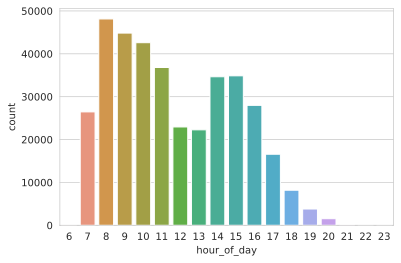

In [210]:
sns.countplot(x='hour_of_day', data=df)

In [211]:
#Checking relation between gender and no_show
gender_noshow = pd.crosstab(index=df["gender"],columns=df["no_show"])
gender_noshow

no_show,noshow,showup
gender,,
F,154277,94282
M,75503,47881


(array([0, 1]), <a list of 2 Text major ticklabel objects>)

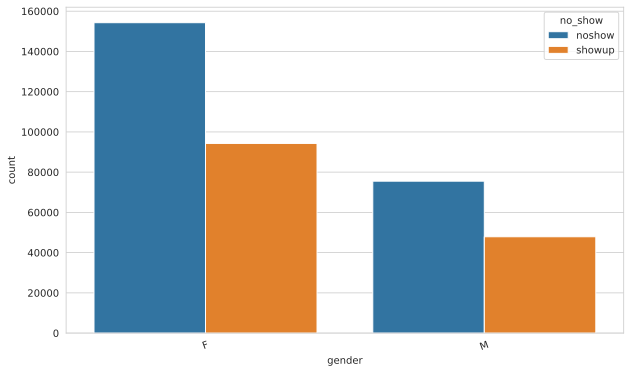

In [212]:
plt.figure(figsize = (10,6))
sns.countplot(x='gender', hue='no_show', data=df, order = df['gender'].value_counts().index)
plt.xticks(rotation=20)

In [0]:
cat_features = ['diabetes', 'alcoholism', 'hypertension', 'scholarship', 'handicap', 'sms_received' ]

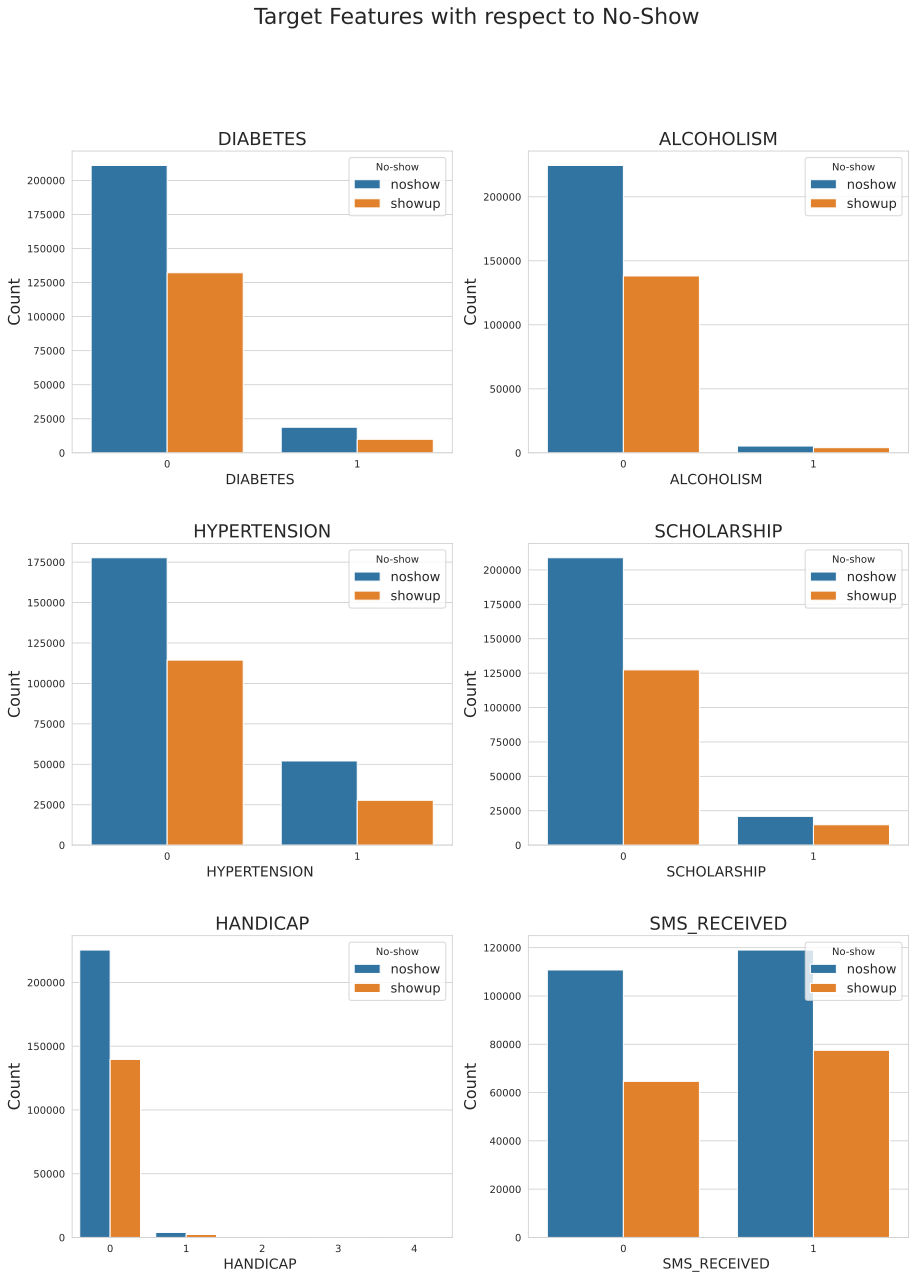

In [214]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,20))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Target Features with respect to No-Show', fontsize=22)

for ax, catplot in zip(axes.flatten(), df[cat_features].columns):
    sns.countplot(x=catplot, data=df, hue='no_show', ax=ax)
    ax.set_title(catplot.upper(), fontsize=18)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_xlabel(f'{catplot.upper()} ', fontsize=14)
    ax.legend(title='No-show', fontsize=13 )

In [215]:
#To confirm the above result checking the pvalue

chi_test_var = ['diabetes', 'alcoholism', 'hypertension', 'scholarship', 'handicap', 'sms_received', 'waiting_time' ]
for column in (chi_test_var):
    chi2, p, dof,ex = chi2_contingency(pd.crosstab(index=df[column], columns=df["no_show"]), correction=False)
    print ('chi-squared test- p value for {} is: {r:6.5f}'. format(column,r = p))

chi-squared test- p value for diabetes is: 0.00000
chi-squared test- p value for alcoholism is: 0.00000
chi-squared test- p value for hypertension is: 0.00000
chi-squared test- p value for scholarship is: 0.00000
chi-squared test- p value for handicap is: 0.11382
chi-squared test- p value for sms_received is: 0.00000
chi-squared test- p value for waiting_time is: 0.00000


### Model Implementation



In [0]:
#Converting Categprical Variable to numeric 

from sklearn import metrics, preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

df['gender'] = pd.get_dummies(df['gender'])

le = preprocessing.LabelEncoder()
df['age'] = le.fit_transform(df['age'])

le = preprocessing.LabelEncoder()
df['appointment_month'] = le.fit_transform(df['appointment_month'])

le = preprocessing.LabelEncoder()
df['hour_of_day'] = le.fit_transform(df['hour_of_day'])

le = preprocessing.LabelEncoder()
df['waiting_time'] = le.fit_transform(df['waiting_time'])

df['no_show'] = pd.get_dummies(df['no_show'])

In [0]:
#split data
features = ['gender', 'age', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received', 'waiting_time',
           'appointment_month', 'hour_of_day' ]
X = df[features]
y = df['no_show']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 1)

In [241]:

print('Shape of X train data: ',X_train.shape)
print('Shape of X test data: ',X_test.shape)
print('Shape of X validation data: ',X_val.shape)
print('Shape of Y train data: ', y_train.shape)
print('Shape of Y test data: ', y_test.shape)
print('Shape of Y validation data: ',y_val.shape)

Shape of X train data:  (195270, 11)
Shape of X test data:  (111583, 11)
Shape of X validation data:  (65090, 11)
Shape of Y train data:  (195270,)
Shape of Y test data:  (111583,)
Shape of Y validation data:  (65090,)


### Logistic Regression

In [223]:

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

lr = LogisticRegression()

# Fit the model to the data
lr = lr.fit(X_train, y_train)

print ("Logistic Regression Model")
lr_auc = roc_auc_score(y_test, lr.predict(X_test))

print ("Logistic Regression AUC = %2.2f" % lr_auc)

lr2 = lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
print(classification_report(y_test, lr.predict(X_test)))



 ---Logistic Regression Model---
Logistic Regression AUC = 0.50
              precision    recall  f1-score   support

           0       0.44      0.01      0.03     42663
           1       0.62      0.99      0.76     68920

    accuracy                           0.62    111583
   macro avg       0.53      0.50      0.39    111583
weighted avg       0.55      0.62      0.48    111583



In [225]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

methods_data = {"Linear Regression": (X_train, y_train)}

for method in methods_data.keys():
    #scoring=['roc_auc', 'accuracy']
    lr_results_acc = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], cv=5, scoring='accuracy')
    lr_results = cross_val_score(LogisticRegression(), methods_data[method][0], methods_data[method][1], scoring='roc_auc')
    print(f"The best AUC Score for {method} data:")
    print (lr_results.mean())
    print("Accuracy: ", lr_results_acc.mean())

The best AUC Score for Linear Regression data:
0.561406783589606
Accuracy:  0.6165821682798176


### Random Forest Classifier

In [226]:
#Implementing Random Forest Classifier to predict no-show

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score,accuracy_score,roc_auc_score

RFC = RandomForestClassifier(max_depth = 4, random_state = 60)
rf_parameter = {
        'n_estimators': 70, 
        'min_samples_leaf': 30
    }

# Fit the model to the data
RFC = RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)

RFC_auc = accuracy_score(y_test, y_pred)

print ("RFC accuracy score = %2.2f" % RFC_auc)
print("RFC ROC score = %2.2f" % roc_auc_score(y_test, y_pred))


RFC accuracy score = 0.62
RFC ROC score = 0.50


### Gaussian Naive Bayes Classifier

In [227]:
from sklearn.naive_bayes import GaussianNB

GNB = GaussianNB()

# Fit the model to the data
GNB = GNB.fit(X_train, y_train)

GNB_auc = accuracy_score(y_test, GNB.predict(X_test))

print ("Naive Bayes accuracy scoure= %2.2f" % GNB_auc)
print ("Naive Bayes ROC score= %2.2f" % roc_auc_score(y_test, GNB.predict(X_test)))

Naive Bayes accuracy scoure= 0.60
Naive Bayes ROC score= 0.52


### XGBoost Classifier

In [0]:
import xgboost as xgb

param_dist = {'objective':'binary:logistic', 'n_estimators':2}

xgm = xgb.XGBModel(**param_dist)

xgm.fit(X_train, y_train)

predict_train = model.predict(X_train)

In [228]:
from xgboost import XGBClassifier

# Create the Original training sets
methods_data = {"Original": (X_train, y_train)}

# Loop through training sets and apply 5-Fold CV using XGBoost Classifier
# By default in cross_val_score StratifiedCV is used
for method in methods_data.keys():
    lr_results = cross_val_score(XGBClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='roc_auc')
    print(f"The best roc_auc Score for {method} data:")
    print (lr_results.mean())

The best roc_auc Score for Original data:
0.655063160152059


In [229]:
#checking accuracy 
for method in methods_data.keys():
    lr_results = cross_val_score(XGBClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='accuracy')
    print(f"The best accuracy Score for {method} data:")
    print (lr_results.mean())

The best accuracy Score for Original data:
0.6476878168689507


In [0]:
#implementing GridSearchCV and XGBoost Classifier

from sklearn.model_selection import GridSearchCV

gbm_param_grid = {
'subsample': [0.9,1],
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
  'learning_rate':[0.1,0.05],
 'n_estimators':[200,300]   
}

xgb_cl=XGBClassifier(objective= 'binary:logistic', nthread=6, tree_method='gpu_hist', eval_metric='auc',n_gpus=1,max_bin=16)

grid_mse = GridSearchCV(estimator=xgb_cl,param_grid=gbm_param_grid,scoring='roc_auc', cv=5, verbose=1,n_jobs=-1)
grid_mse.fit(X_train, y_train)
print("Best parameters found: ",grid_mse.best_params_)
print("Best ROC found: ", np.sqrt(np.abs(grid_mse.best_score_)))

In [0]:
#XGB=XGBClassifier(objective= 'binary:logistic', nthread=6, tree_method='gpu_hist', eval_metric='auc',n_gpus=1,max_bin=16,**grid_mse.best_params_)
#XGB = grid_mse.fit(X_train, y_train)

XGB_auc = roc_auc_score(y_test, grid_mse.predict(X_test))

print ("accuracy scoure= %2.2f" % XGB_auc)

### Catboost

In [238]:
pip install catboost

     |████████████████████████████████| 64.4MB 56kB/s 


In [0]:
#implementing CatBoostClassfier

from catboost import CatBoostClassifier
for method in methods_data.keys():
    lr_results = cross_val_score(CatBoostClassifier(), methods_data[method][0], methods_data[method][1], cv=5, scoring='accuracy')
    print(f"The best accuracy Score for {method} data:")
    print (lr_results.mean())

In [240]:
params = {'iterations':[50], 'depth':[3], 'learning_rate':[0.1]}
    
cb_clf = CatBoostClassifier()

grid_cb = GridSearchCV(estimator=cb_clf,param_grid=params,scoring='roc_auc', cv=5, verbose=1,n_jobs=-1)
grid_cb.fit(X_train, y_train)
print("Best parameters found: ",grid_cb.best_params_)
print("Best ROC found: ", np.sqrt(np.abs(grid_cb.best_score_)))
print("Best ROC for Test found: ", roc_auc_score(y_test, grid_cb.predict(X_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished


0:	learn: 0.6836948	total: 34.9ms	remaining: 1.71s
1:	learn: 0.6760265	total: 67.3ms	remaining: 1.61s
2:	learn: 0.6698266	total: 106ms	remaining: 1.66s
3:	learn: 0.6646345	total: 135ms	remaining: 1.55s
4:	learn: 0.6604581	total: 164ms	remaining: 1.48s
5:	learn: 0.6565599	total: 193ms	remaining: 1.42s
6:	learn: 0.6536002	total: 222ms	remaining: 1.36s
7:	learn: 0.6511666	total: 255ms	remaining: 1.34s
8:	learn: 0.6490962	total: 285ms	remaining: 1.3s
9:	learn: 0.6473380	total: 315ms	remaining: 1.26s
10:	learn: 0.6455863	total: 347ms	remaining: 1.23s
11:	learn: 0.6441439	total: 377ms	remaining: 1.19s
12:	learn: 0.6429506	total: 408ms	remaining: 1.16s
13:	learn: 0.6421450	total: 444ms	remaining: 1.14s
14:	learn: 0.6414712	total: 482ms	remaining: 1.13s
15:	learn: 0.6407309	total: 513ms	remaining: 1.09s
16:	learn: 0.6401835	total: 543ms	remaining: 1.05s
17:	learn: 0.6395283	total: 581ms	remaining: 1.03s
18:	learn: 0.6391296	total: 614ms	remaining: 1s
19:	learn: 0.6387863	total: 645ms	remaining